In [ ]:
import argparse
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from scipy.sparse.construct import vstack
from features import get_dataframe, update_text, update_ngrams, update_lexicon, upadate_linguistic, update_user, get_features, get_lable
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--train', dest='train', required=False, default='data/train.jsonl',
                    help='Full path to the training file')
parser.add_argument('--test', dest='test', required=False, default='data/val.jsonl',
                    help='Full path to the evaluation file')
parser.add_argument('--user_data', dest='user_data', required=False, default='data/users.json',
                    help='Full path to the user data file')
parser.add_argument('--model', dest='model', required=False, default='Ngram+Lex+Ling+User',
                    choices=["Ngram", "Ngram+Lex", "Ngram+Lex+Ling", "Ngram+Lex+Ling+User"],
                    help='The name of the model to train and evaluate.')
parser.add_argument('--lexicon_path', dest='lexicon_path', required=False, default='lexica/',
                    help='The full path to the directory containing the lexica.'
                            ' The last folder of this path should be "lexica".')
parser.add_argument('--outfile', dest='outfile', required=False, default='out.txt',
                    help='Full path to the file we will write the model predictions')
                    
args = parser.parse_args("")

In [3]:
df_train_loc = os.path.join('df_train.pkl')
df_test_loc = os.path.join('df_test.pkl')
df_user_loc = os.path.join('df_user.pkl')



if os.path.isfile(df_train_loc) and os.path.isfile(df_test_loc):
    df_train = pd.read_pickle(df_train_loc)
    df_test = pd.read_pickle(df_test_loc)
    df_user = pd.read_pickle(df_user_loc)

else:

    start = time.time()

    df_train, df_test = get_dataframe(args.train, args.test)
    update_text(df_train, df_test)
    update_ngrams(df_train, df_test, feature_number=1000)
    update_lexicon(df_train, df_test, args.lexicon_path)
    upadate_linguistic(df_train, df_test)
    df_train, df_test, df_user = update_user(df_train, df_test, args.user_data)

    end = time.time()
    print("Data Preprocessiong Cost:", round(end - start),'s.')

    df_train.to_pickle(df_train_loc)
    df_test.to_pickle(df_test_loc)
    df_user.to_pickle(df_user_loc)


c:\Users\fff32\Desktop\Natural Language Processing\Homework_1\code\features.py:67: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_CL = pd.read_csv(CL_csv, sep="_|,", names=['word', 'part', 'sentiment'])


Data Preprocessiong Cost: 62 s.


In [4]:
import itertools
def get_all_combinations(l : list, choose2=False) -> list:
    ll = []
    for L in range(0, len(l)+1):
        for subset in itertools.combinations(l, L):
            if choose2:
                if len(list(subset)) == 2:
                    ll.append(list(subset))
            else:
                ll.append(list(subset))
    return ll

lexicons_list = ["CL", "NVL"]
ling_feature_list = ['Length', 'R2O', 'Personal_pronouns', 'Modals', 'Links', 'Questions']
user_feature_list = ['education','ethnicity', 'gender', 'income', 'joined', 'party', 'political_ideology', 'relationship', 'religious_ideology']
all_feature_list = list(lexicons_list+ling_feature_list+user_feature_list)

# Proformance test

==================== Ngram ====================
Total Featurs: 2000
Accuracy score:  0.7443609022556391
Accuracy score on Train:  0.8944723618090452
              precision    recall  f1-score   support

         Con       0.72      0.85      0.78       211
         Pro       0.79      0.63      0.70       188

    accuracy                           0.74       399
   macro avg       0.75      0.74      0.74       399
weighted avg       0.75      0.74      0.74       399

==================== Ngram+Lex ====================
Lexicon used: Connotation NRC-VAD 
Total Featurs: 2012
Accuracy score:  0.7493734335839599
Accuracy score on Train:  0.871859296482412
              precision    recall  f1-score   support

         Con       0.72      0.86      0.78       211
         Pro       0.80      0.62      0.70       188

    accuracy                           0.75       399
   macro avg       0.76      0.74      0.74       399
weighted avg       0.76      0.75      0.74       399

==========

C:\Users\fff32\miniconda3\envs\NLP-hw1\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy score:  0.7443609022556391
Accuracy score on Train:  0.7939698492462312
              precision    recall  f1-score   support

         Con       0.71      0.88      0.78       211
         Pro       0.81      0.60      0.69       188

    accuracy                           0.74       399
   macro avg       0.76      0.74      0.74       399
weighted avg       0.76      0.74      0.74       399

==================== Ngram+Lex+Ling+User ====================
Lexicon used: Connotation NRC-VAD 
Linguistic features: Length R2O Personal_pronouns Modals Links Questions 
User features: education ethnicity gender income joined party political_ideology relationship religious_ideology 
Total Featurs: 2460
Accuracy score:  0.7994987468671679
Accuracy score on Train:  0.8743718592964824
              precision    recall  f1-score   support

         Con       0.77      0.89      0.82       211
         Pro       0.85      0.70      0.77       188

    accuracy                           0.8

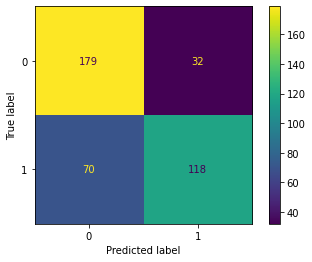

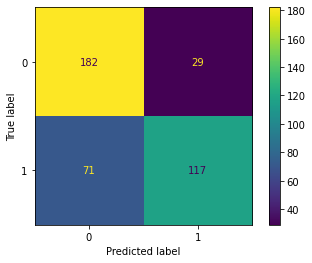

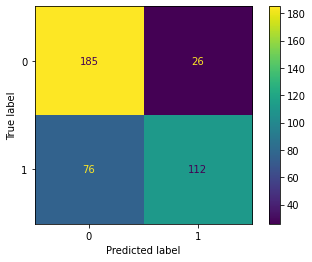

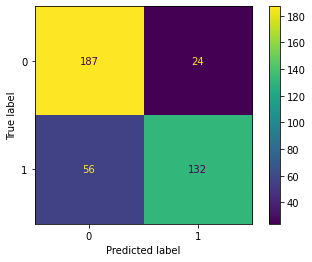

In [5]:
for md in ["Ngram", "Ngram+Lex", "Ngram+Lex+Ling", "Ngram+Lex+Ling+User"]:
    print('====================', md,'====================')
    x_train, x_test = get_features(df_train, df_test, df_user, model = md)
    y_train, y_test = get_lable(df_train, df_test)
    print("Total Featurs:", x_train.shape[1])
    clf = LogisticRegression(solver='liblinear')
    clf.fit(x_train, y_train)
    y_predicted = clf.predict(x_test)
    print("Accuracy score: ",accuracy_score(y_test, y_predicted))
    print("Accuracy score on Train: ",accuracy_score(y_train, clf.predict(x_train)))
    plot_confusion_matrix(clf, x_test, y_test)
    print(classification_report(y_test, y_predicted, target_names=['Con','Pro']))

# Find Best feature_number

In [ ]:
column_names = ["Max Feature","5F-CV Mean", "scores"]
df_record = pd.DataFrame(columns = column_names)
for fn in range(9600, 9700, 50):
    print(fn)
    df_train = df_train.drop(columns=["Pro_ngram", "Con_ngram"])
    df_test = df_test.drop(columns=["Pro_ngram", "Con_ngram"])
    update_ngrams(df_train, df_test, feature_number=fn)
    x_train, x_test = get_features(df_train, df_test, model = "Ngram")
    y_train, y_test = get_lable(df_train, df_test)
    x = vstack([x_train,x_test])
    y = y_train + y_test
    clf = LogisticRegression(solver='liblinear')
    scores = cross_val_score(clf, x, y, cv=5 ,scoring='accuracy')
    mean_score = np.mean(scores)
    record = {"Max Feature":fn, "5F-CV Mean":mean_score, "scores":scores}
    df_record = df_record.append(record,ignore_index=True)

df_record.to_csv(os.path.join('log/Ngram_FN_4.csv'))

# Cross Valid All combination

In [ ]:
column_names = ["Lex","Ling","User","5FCV Mean", "Scores"]
df_record = pd.DataFrame(columns = column_names)
for lex in get_all_combinations(lexicons_list):
    for ling in get_all_combinations(ling_feature_list, choose2=True):
        for user in get_all_combinations(user_feature_list, choose2=True):
            x_train, x_test = get_features(df_train, df_test, model = args.model,lex_list=lex, ling_list=ling, user_list=user)
            y_train, y_test = get_lable(df_train, df_test)
            x = vstack([x_train,x_test])
            y = y_train + y_test
            clf = LogisticRegression(solver='liblinear', max_iter=500)
            scores = cross_val_score(clf, x, y, cv=5 ,scoring='accuracy')
            mean_score = np.mean(scores)
            record = {"Lex":lex,"Ling":ling,"User":user,"5FCV Mean":mean_score, "Scores":scores}
            df_record = df_record.append(record,ignore_index=True)

df_record.to_csv(os.path.join('Traversal.csv'))

# Ablation

In [ ]:
column_names = ["target_feature","mean_score", "scores"]
df_record = pd.DataFrame(columns = column_names)

for feature in all_feature_list:

    ling_feature_list = ['Length', 'R2O', 'Personal_pronouns', 'Modals', 'Links', 'Questions']
    user_feature_list = ['education','ethnicity', 'gender', 'income', 'joined', 'party', 'political_ideology', 'relationship', 'religious_ideology']
    lexicons_list = ["CL", "NVL"]
        
    if feature in ling_feature_list:
        ling_feature_list.remove(feature)
    if feature in user_feature_list:
        user_feature_list.remove(feature)
    if feature in lexicons_list:
        lexicons_list.remove(feature)

    x_train, x_test = get_features(df_train, df_test, model = args.model,lex_list=lexicons_list, ling_list=ling_feature_list, user_list=user_feature_list)
    y_train, y_test = get_lable(df_train, df_test)

    x = vstack([x_train,x_test])
    y = y_train + y_test
    clf = LogisticRegression(solver='liblinear', max_iter=500)
    start = time.time()
    scores = cross_val_score(clf, x, y, cv=5 ,scoring='accuracy')
    end = time.time()
    mean_score = np.mean(scores)
    record = {"target_feature":feature, "mean_score":mean_score, "scores":scores}
    df_record = df_record.append(record,ignore_index=True)


df_record.to_csv(os.path.join('Ablation.csv'))

# Ablation R vs O

In [ ]:
df_train_r = df_train[df_train['category']=='Religion']
df_train_nr = df_train[df_train['category']!='Religion']
df_test_r = df_test[df_test['category']=='Religion']
df_test_nr = df_test[df_test['category']!='Religion']

column_names = ["Religion","Ablation Feature","5FCV Mean", "Scores", "Norm"]
df_record = pd.DataFrame(columns = column_names)


for feature in all_feature_list:

    ling_feature_list = ['Length', 'R2O', 'Personal_pronouns', 'Modals', 'Links', 'Questions']
    user_feature_list = ['education','ethnicity', 'gender', 'income', 'joined', 'party', 'political_ideology', 'relationship', 'religious_ideology']
    lexicons_list = ["CL", "NVL"]
        
    if feature in ling_feature_list:
        ling_feature_list.remove(feature)
    if feature in user_feature_list:
        user_feature_list.remove(feature)
    if feature in lexicons_list:
        lexicons_list.remove(feature)

    for religion in [True, False]:

        if religion:
            x_train, x_test = get_features(df_train_r, df_test_r, norm=None, model = args.model,lex_list=lexicons_list, ling_list=ling_feature_list, user_list=user_feature_list)
            y_train, y_test = get_lable(df_train_r, df_test_r)
        else:
            x_train, x_test = get_features(df_train_nr, df_test_nr, norm=None, model = args.model,lex_list=lexicons_list, ling_list=ling_feature_list, user_list=user_feature_list)
            y_train, y_test = get_lable(df_train_nr, df_test_nr)

        x = vstack([x_train,x_test])
        y = y_train + y_test
        clf = LogisticRegression(solver='liblinear', max_iter=500)
        start = time.time()
        scores = cross_val_score(clf, x, y, cv=5 ,scoring='accuracy')
        end = time.time()
        mean_score = np.mean(scores)
        record = {"Religion":religion, "Ablation Feature":feature ,"5FCV Mean":mean_score, "Scores":scores, "Norm":norm}
        df_record = df_record.append(record,ignore_index=True)


df_record.to_csv(os.path.join('Ablation_ReligionVsOther_Normalize.csv'))